# Calculate Spatiotemporal Power Spectrum of Movies

After Video Frames have been temporally synced on a common timeframe with the eye trackers, we can extract video frames knowing they are temporally synced to the eye tracker. 

## Dependencies

In [1]:
import os, stat
import numpy as np
import matplotlib.pyplot as plt
import imp

import utils.run_analysis as ana

import stftoolkit as stf

## Parameters

*** NOTE: REALLY NEED TO CHECK ON THE VALUES FOR HORIZONTAL AND VERTICAL FOV ***

In [85]:
base_dir = '/data_repo/bravo'
data_dir = os.path.join(base_dir, 'raw_data')
output_dir = os.path.join(base_dir, 'analysis')

fps = 200

###DEFINITELY NEED TO CHECK ON THESE VALUES
horizontal_fov_deg = 80
vertical_fov_deg = 62

img_dims=(1544,2064)
save_batchsize = 200

chunk_secs = 5
chunk_pix = 256

num_chunks = 10

cosine_window = True

vertical_ppd = img_dims[0]/vertical_fov_deg
horizontal_ppd = img_dims[1]/horizontal_fov_deg
ppd = np.mean((vertical_ppd, horizontal_ppd))
print(f'Vertical PPD: {vertical_ppd:.2f}, Horizontal PPD {horizontal_ppd:.2f}, taking average {ppd:.2f}')

Vertical PPD: 24.90, Horizontal PPD 25.80, taking average 25.35


## Specify Directories for Exmaple

In [24]:
example_subject = 'jf'
example_trial = 'cell_phone_1'
example_camera = 'cy'
trial_directory = os.path.join(data_dir, example_subject, example_trial, 'pre')
camera_dir = os.path.join(trial_directory,'scene_camera')

analysis_folder = os.path.join(output_dir, example_subject, example_trial,'')
common_timeline_file = os.path.join(analysis_folder,'common_timeline.npy')

#three trace conditions: true, none, temporal_match, spatial_match 
trace='none'

## Create Traces To Overlay

*** For now, only doing control conditions with random box in scene window. Later, the no trace condition should be MATCHED to a true fixation point START. ***

In [25]:
timeline = np.load(common_timeline_file)
timeline_stamps = timeline[:0]
timeline_ximea = timeline[:,1].astype(int)
timeline_pupil = timeline[:,2].astype(int)
timeline_task = timeline[:,3].astype(int)

#only use timelines during task
timeline_ximea = timeline_ximea[timeline_task==1]
timeline_pupil = timeline_pupil[timeline_task==1]

In [26]:
#generate a trace
chunk_fs = int(chunk_secs*fps)
if(trace == 'none'):
    trace_xy_corner = np.tile([np.random.randint(0,img_dims[0]-chunk_pix), np.random.randint(0,img_dims[1])-chunk_pix],(chunk_fs,1)) #top left corner
    trace_f_start = np.random.randint(0, len(timeline_pupil) - chunk_fs)
    trace_f = np.arange(trace_f_start, trace_f_start+chunk_fs)

    trace_ximea_fnum = timeline_ximea[trace_f]
    trace_pupil_fnum = timeline_pupil[trace_f]

## Extract Movie at Trace x, y, f position

In [27]:
#analysis_folder
start = 2000
trace_ximea_fnum = range(start, chunk_secs*fps+start)

In [28]:
#code to grab full size movie at trace time
#pull the movie at these frame numbers
#full_movie = np.zeros((len(trace_f),*img_dims,3))
#for i, f in enumerate(trace_f):
#    full_movie[i] = ana.ximea_get_frame(f, save_batchsize, example_camera, camera_dir, img_dims=(1544,2064), normalize=True)

import imageio

movie_chunk = np.zeros((len(trace_f), chunk_pix, chunk_pix, 3))

for i, f in enumerate(trace_ximea_fnum):
    frame = imageio.imread(os.path.join(analysis_folder,'pngs','cy',f'frame_{f}.png'))
#   frame = ana.ximea_get_frame(timeline_ximea[i], save_batchsize, example_camera, camera_dir, img_dims=(1544,2064), normalize=True)
    #frame = frame/np.max(frame)
        
    movie_chunk[i] = frame[trace_xy_corner[i,0]:trace_xy_corner[i,0]+chunk_pix, 
                           trace_xy_corner[i,1]:trace_xy_corner[i,1]+chunk_pix]



In [29]:
movie_chunk_norm = movie_chunk/np.max(movie_chunk,axis=0)

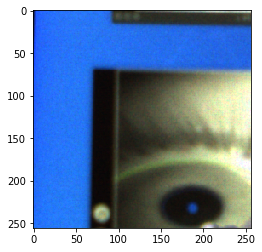

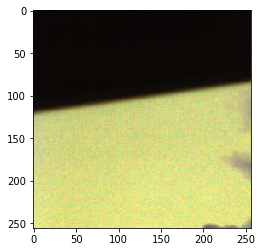

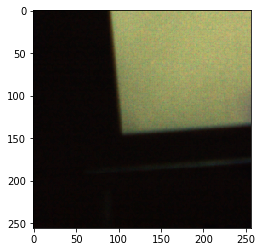

In [31]:
plt.imshow(movie_chunk_norm[0])
plt.show()

plt.imshow(movie_chunk_norm[np.shape(movie_chunk_norm)[0]//2])
plt.show()

plt.imshow(movie_chunk_norm[-1])
plt.show()


## Calculate the Spatiotemporal Fourier Transform of this Chunk

In [33]:
ps_3d, ps_2d, fqs_space, fqs_time = stf.st_ps(movie_chunk, ppd, fps, cosine_window=False, rm_dc=True)

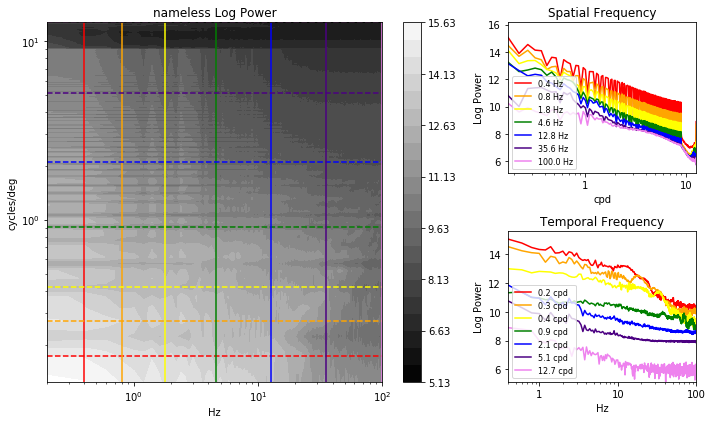

In [84]:
stf.da_plot_power(ps_2d.T, fqs_space, fqs_time, show_onef_line=False)

## Take the Average of Many Chunks and create FT plot

In [ ]:
chunk_fs = int(chunk_secs*fps)

ps_3d_mean = np.zeros_like(ps_3d)
ps_2d_mean = np.zeros_like(ps_2d)

print(f'Taking mean of {num_chunks} chunks...')
for i in range(num_chunks):
    if(trace == 'none'):
        trace_xy_corner = np.tile([np.random.randint(0,img_dims[0]-chunk_pix-1), 
                                   np.random.randint(0,img_dims[1])-chunk_pix-1],
                                  (chunk_fs,1)) #top left corner
        trace_f_start = np.random.randint(0, len(timeline_pupil) - chunk_fs)
        trace_f = np.arange(trace_f_start, trace_f_start+chunk_fs)

        #trace_ximea_fnum = timeline_ximea[trace_f]
        #trace_pupil_fnum = timeline_pupil[trace_f]
        #for now since we don't have all our data yet
        start = np.random.randint(0,6800-chunk_fs)
        print(start)
        trace_ximea_fnum = range(start, chunk_secs*fps+start)

        movie_chunk = np.zeros((len(trace_f), chunk_pix, chunk_pix, 3))
        print(movie_chunk.shape)
        print(trace_xy_corner[i,0], trace_xy_corner[i,1] )

        for i, f in enumerate(trace_ximea_fnum):
            frame = imageio.imread(os.path.join(analysis_folder,'pngs','cy',f'frame_{f}.png'))
        #   frame = ana.ximea_get_frame(timeline_ximea[i], save_batchsize, example_camera, camera_dir, img_dims=(1544,2064), normalize=True)
            #frame = frame/np.max(frame)
            movie_chunk[i] = frame[trace_xy_corner[i,0]:trace_xy_corner[i,0]+chunk_pix, 
                                   trace_xy_corner[i,1]:trace_xy_corner[i,1]+chunk_pix]
            
        ps_3d, ps_2d, fqs_space, fqs_time = stf.st_ps(movie_chunk, ppd, fps, cosine_window=False, rm_dc=True)
        ps_3d_mean += ps_3d
        ps_2d_mean += ps_2d
    print('*',end='')

ps_3d_mean = ps_3d_mean/num_chunks
ps_2d_mean = ps_2d_mean/num_chunks
        
            

Taking mean of 10 chunks...
1096
(1000, 256, 256, 3)
876 1259
*1176
(1000, 256, 256, 3)
295 1206


In [ ]:
stf.da_plot_power(ps_2d_mean.T, fqs_space, fqs_time, show_onef_line=False, figname=f'mean_Power_{num_chunks}_chunks')